# 10장. 회귀 분석으로 연속적 타깃 변수 예측하기

**아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.**

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch10/ch10.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/python-machine-learning-book-2nd-edition/blob/master/code/ch10/ch10.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

`watermark`는 주피터 노트북에 사용하는 파이썬 패키지를 출력하기 위한 유틸리티입니다. `watermark` 패키지를 설치하려면 다음 셀의 주석을 제거한 뒤 실행하세요.

In [ ]:
#!pip install watermark

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,pandas,matplotlib,sklearn,seaborn

last updated: 2019-04-26 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.3
pandas 0.24.2
matplotlib 3.0.3
sklearn 0.20.3
seaborn 0.9.0


맷플롯립을 기반의 그래픽 라이브러리인 seaborn 패키지는 다음 명령으로 설치할 수 있습니다.

    conda install seaborn

또는

    pip install seaborn

# 주택 데이터셋 탐색

## 데이터프레임으로 주택 데이터셋 읽기

이 설명은 [https://archive.ics.uci.edu/ml/datasets/Housing](https://archive.ics.uci.edu/ml/datasets/Housing)을 참고했습니다:

속성:
    
<pre>
1. CRIM: 도시의 인당 범죄율
2. ZN: 25,000 평방 피트가 넘는 주택 비율
3. INDUS: 도시에서 소매 업종이 아닌 지역 비율
4. CHAS: 찰스강 인접 여부(강 주변=1, 그 외=0)
5. NOX: 일산화질소 농도(10ppm 당)
6. RM: 주택의 평균 방 개수
7. AGE: 1940년 이전에 지어진 자가 주택 비율
8. DIS: 다섯 개의 보스턴 고용 센터까지 가중치가 적용된 거리
9. RAD: 방사형으로 뻗은 고속도로까지 접근성 지수
10. TAX: $10,000당 재산세율
11. PTRATIO: 도시의 학생-교사 비율
12. B: 1000(Bk - 0.63)^2, 여기에서 Bk는 도시의 아프리카계 미국인 비율
13. LSTAT: 저소득 계층의 비율
14. MEDV: 자가 주택의 중간 가격($1,000 단위)
</pre>

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/rasbt/'
                 'python-machine-learning-book-2nd-edition'
                 '/master/code/ch10/housing.data.txt',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


## 데이터셋의 중요 특징을 시각화하기

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

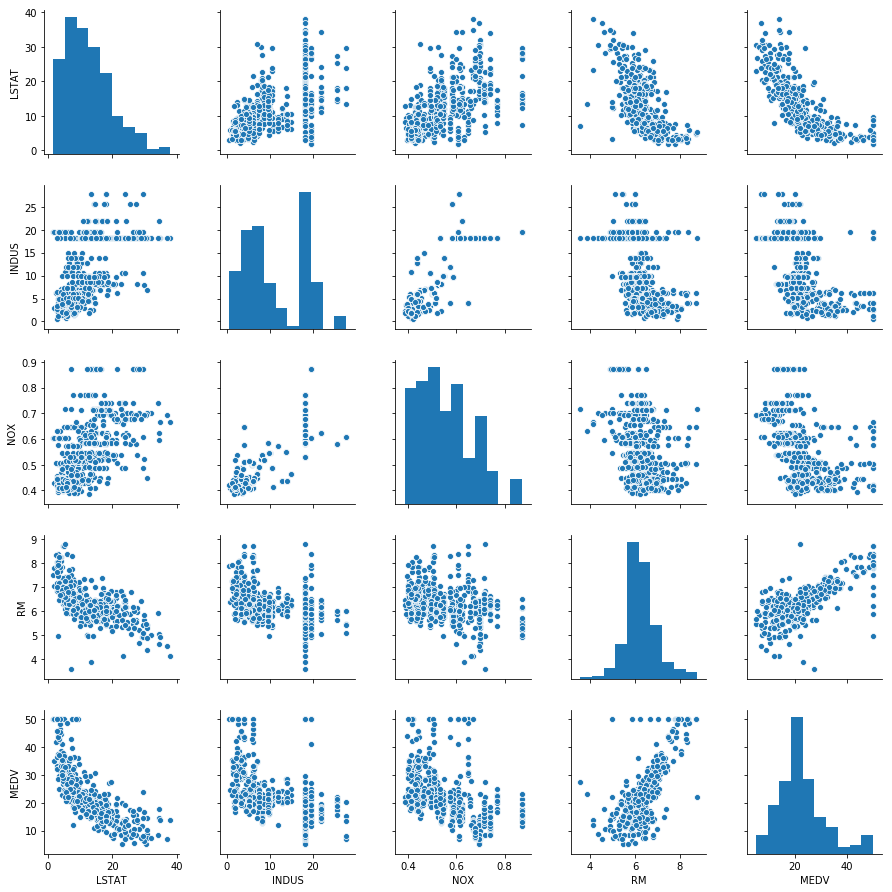

In [4]:
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], height=2.5)
plt.tight_layout()
plt.show()

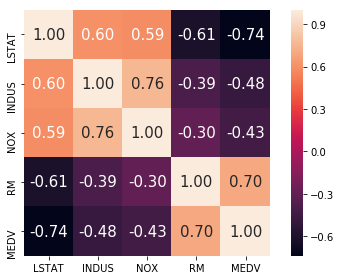

In [5]:
import numpy as np


cm = np.corrcoef(df[cols].values.T)
#sns.set(font_scale=1.5)
hm = sns.heatmap(cm,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 annot_kws={'size': 15},
                 yticklabels=cols,
                 xticklabels=cols)

plt.tight_layout()
plt.show()

# 최소 제곱 선형 회귀 모델 구현하기

## 경사 하강법으로 회귀 모델의 파라미터 구하기

In [6]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [7]:
X = df[['RM']].values
y = df['MEDV'].values

In [8]:
from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()

In [9]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)

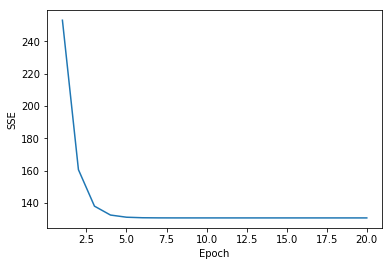

In [10]:
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
plt.show()

In [11]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

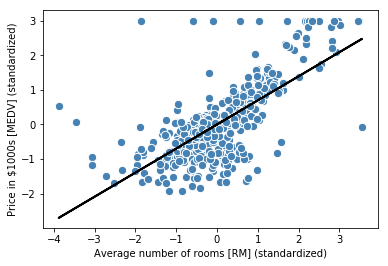

In [12]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

plt.show()

In [13]:
print('기울기: %.3f' % lr.w_[1])
print('절편: %.3f' % lr.w_[0])

기울기: 0.695
절편: -0.000


In [14]:
num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)
print("$1,000 단위 가격: %.3f" % sc_y.inverse_transform(price_std))

$1,000 단위 가격: 10.840


## 사이킷런으로 회귀 모델의 가중치 추정하기

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('기울기: %.3f' % slr.coef_[0])
print('절편: %.3f' % slr.intercept_)

기울기: 9.102
절편: -34.671


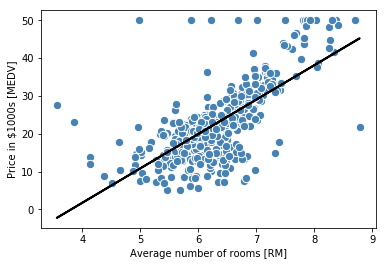

In [17]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

plt.show()

**정규 방정식**을 사용한 방법:

In [18]:
# 1로 채워진 열 벡터 추가
Xb = np.hstack((np.ones((X.shape[0], 1)), X))
w = np.zeros(X.shape[1])
z = np.linalg.inv(np.dot(Xb.T, Xb))
w = np.dot(z, np.dot(Xb.T, y))

print('기울기: %.3f' % w[1])
print('절편: %.3f' % w[0])

기울기: 9.102
절편: -34.671


# RANSAC을 사용하여 안정된 회귀 모델 훈련하기

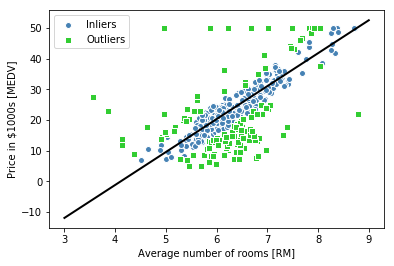

In [19]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(), 
                         max_trials=100, 
                         min_samples=50, 
                         loss='absolute_loss', 
                         residual_threshold=5.0, 
                         random_state=0)


ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

plt.show()

In [20]:
print('기울기: %.3f' % ransac.estimator_.coef_[0])
print('절편: %.3f' % ransac.estimator_.intercept_)

기울기: 10.735
절편: -44.089


# 선형 회귀 모델의 성능 평가

In [21]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

In [22]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

In [23]:
import numpy as np
import scipy as sp

ary = np.array(range(100000))

In [24]:
%timeit np.linalg.norm(ary)

54.1 µs ± 153 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [25]:
%timeit sp.linalg.norm(ary)

55.2 µs ± 164 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [26]:
%timeit np.sqrt(np.sum(ary**2))

86.1 µs ± 41.6 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


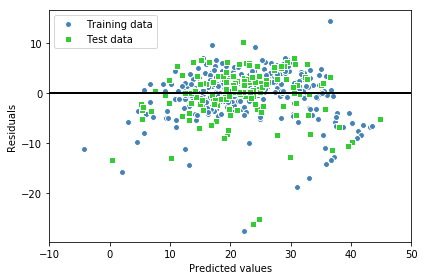

In [27]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 19.958, 테스트 MSE: 27.196
훈련 R^2: 0.765, 테스트 R^2: 0.673


# 회귀에 규제 적용하기

In [29]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


In [30]:
print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 20.926, 테스트 MSE: 28.876
훈련 R^2: 0.753, 테스트 R^2: 0.653


릿지 회귀:

In [31]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

라쏘 회귀:

In [32]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

엘라스틱 넷 회귀:

In [33]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

# 선형 회귀 모델을 다항 회귀로 변환하기

In [34]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])

In [35]:
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

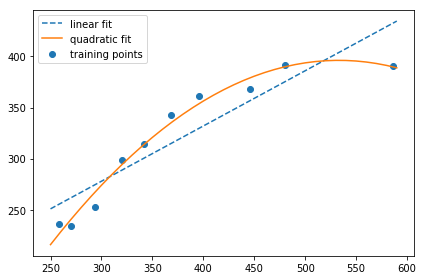

In [36]:
# 선형 특성 학습
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# 이차항 특성 학습
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

# 결과 그래프
plt.scatter(X, y, label='training points')
plt.plot(X_fit, y_lin_fit, label='linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='quadratic fit')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

In [38]:
print('훈련 MSE 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('훈련 R^2 비교 - 선형 모델: %.3f, 다항 모델: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

훈련 MSE 비교 - 선형 모델: 569.780, 다항 모델: 61.330
훈련 R^2 비교 - 선형 모델: 0.832, 다항 모델: 0.982


## 주택 데이터셋을 사용한 비선형 관계 모델링

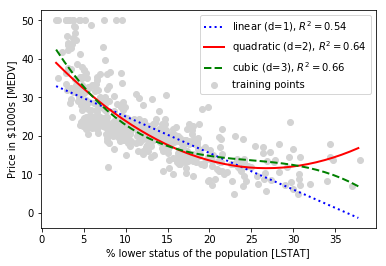

In [39]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# 이차, 삼차 다항식 특성을 만듭니다
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# 학습된 모델을 그리기 위해 특성 범위를 만듭니다
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# 결과 그래프를 그립니다
plt.scatter(X, y, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')

plt.show()

데이터셋을 변환합니다:

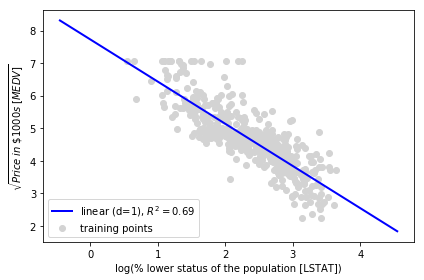

In [40]:
X = df[['LSTAT']].values
y = df['MEDV'].values

# 특성을 변환합니다
X_log = np.log(X)
y_sqrt = np.sqrt(y)

# 학습된 모델을 그리기 위해 특성 범위를 만듭니다
X_fit = np.arange(X_log.min()-1, X_log.max()+1, 1)[:, np.newaxis]

regr = regr.fit(X_log, y_sqrt)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y_sqrt, regr.predict(X_log))

# 결과 그래프를 그립니다
plt.scatter(X_log, y_sqrt, label='training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2)

plt.xlabel('log(% lower status of the population [LSTAT])')
plt.ylabel('$\sqrt{Price \; in \; \$1000s \; [MEDV]}$')
plt.legend(loc='lower left')

plt.tight_layout()
plt.show()

# 랜덤 포레스트를 사용하여 비선형 관계 다루기

## 결정 트리 회귀

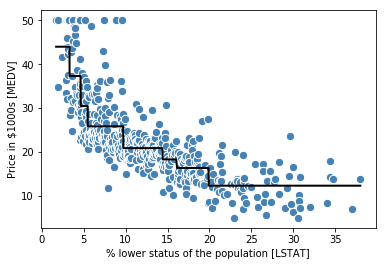

In [41]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.show()

## 랜덤 포레스트 회귀

In [42]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)

In [43]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('훈련 MSE: %.3f, 테스트 MSE: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('훈련 R^2: %.3f, 테스트 R^2: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

훈련 MSE: 1.641, 테스트 MSE: 11.056
훈련 R^2: 0.979, 테스트 R^2: 0.878


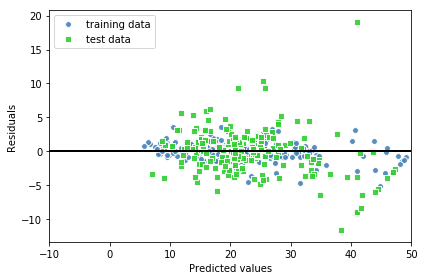

In [44]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()

plt.show()